# CSCE 636: Deep Learning
# UIN: 828002068
# Name: Mamoon Masud
# Submission - 8 
# Architecture - Transfer Learning ( Dense Net )
# Activity Recognition Project - Training Code

In [ ]:
import os
import cv2
import keras
from keras.models import Sequential, Model
from keras.layers import Input, BatchNormalization, Activation, Conv3D, Dropout, Concatenate, AveragePooling3D, MaxPooling3D, Dense, Flatten, GlobalAveragePooling2D
from keras.activations import linear, softmax
from keras.applications import densenet

# Code to train T3D model
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
import keras.backend as K
import traceback

__all__ = ['DenseNet', 'densenet121', 'densenet161']  # with DropOut

In [ ]:
bs_path = '/content/drive/My Drive/DL Proj/Sub_9/Dataset'
d_train = pd.read_csv(os.path.join(bs_path, 'train.csv'))
d_valid = pd.read_csv(os.path.join(bs_path, 'valid.csv'))

In [ ]:
def _DenseLayer(prev_layer, growth_rate, bn_size, drop_rate):
    if prev_layer is None:
        # print('No Layer previous to Dense Layers!!')
        return None
    else:
        x = BatchNormalization()(prev_layer)
    x = Activation('relu')(x)
    x = Conv3D(filters=bn_size * growth_rate, kernel_size=1, strides=1, padding='same')(x)
    x = Dropout(drop_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(filters=growth_rate, kernel_size=3, strides=1, padding='same')(x)
    x = Dropout(drop_rate)(x)

    return x

In [ ]:
def _DenseBlock(prev_layer, num_layers, bn_size, growth_rate, drop_rate):
    x = prev_layer
    for i in range(num_layers):
        layer = _DenseLayer(x, growth_rate, bn_size, drop_rate)
        if layer is None:
            print('Dense Block not created as no previous layers found!!')
            return None
        else:
            x = layer
    return x

In [ ]:
def _Transition(prev_layer, num_output_features):

    # print('In _Transition')
    x = BatchNormalization()(prev_layer)
    x = Activation('relu')(x)
    x = Conv3D(filters=num_output_features, kernel_size=1, strides=1, use_bias=False, padding='same')(x)
    x = AveragePooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2))(x)
    # print('Completed _Transition')
    return x

In [ ]:
def _TTL(prev_layer):
    # print('In _TTL')
    b1 = BatchNormalization()(prev_layer)
    b1 = Activation('relu')(b1)
    # b1 = Conv3D(128, kernel_size=(1), strides=1, use_bias=False, padding='same')(b1)
    b1 = Conv3D(128, kernel_size=(1, 3, 3), strides=1, use_bias=False, padding='same')(b1)

    b2 = BatchNormalization()(prev_layer)
    b2 = Activation('relu')(b2)
    b2 = Conv3D(128, kernel_size=(3, 3, 3), strides=1, use_bias=False, padding='same')(b2)

    b3 = BatchNormalization()(prev_layer)
    b3 = Activation('relu')(b3)
    b3 = Conv3D(128, kernel_size=(4, 3, 3), strides=1, use_bias=False, padding='same')(b3)

    x = keras.layers.concatenate([b1, b2, b3], axis=1)
    # print('completed _TTL')
    return x

In [ ]:
def DenseNet3D(input_shape, growth_rate=32, block_config=(6, 8, 8, 10),
               num_init_features=32, bn_size=4, drop_rate=0, num_classes=2):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """
    #-----------------------------------------------------------------
    inp_2d = (Input(shape=(224,224,3), name='2d_input'))
    pretrained_densenet = densenet.DenseNet169(include_top=False, input_shape=(224,224,3), input_tensor=inp_2d, weights='imagenet')
    for layer in pretrained_densenet.layers:
        layer.trainable = False
    #-----------------------------------------------------------------

    # First convolution-----------------------
    inp_3d = (Input(shape=input_shape, name='3d_input'))


    # need to check padding
    x = (Conv3D(num_init_features, kernel_size=(3, 7, 7),
                strides=2, padding='same', use_bias=False))(inp_3d)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # need to check padding
    x = MaxPooling3D(pool_size=(3, 3, 3), strides=(
        2, 2, 2), padding='valid')(x)

    # Each denseblock
    num_features = num_init_features
    for i, num_layers in enumerate(block_config):
        # print('Pass', i)
        x = _DenseBlock(x, num_layers=num_layers,
                        bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)

        num_features = num_features + num_layers * growth_rate

        if i != len(block_config) - 1:
            # print('Not Last layer, so adding Temporal Transition Layer')

            x = _TTL(x)
            # num_features = 128*3

            x = _Transition(x, num_output_features=num_features)
            num_features = num_features

    # Final batch norm
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = AveragePooling3D(pool_size=(1, 7, 7))(x)
    x = Flatten(name='flatten_3d')(x)
    x = Dense(512, activation='relu')(x)
    #--------------fron 2d densenet model-----------------
    y = GlobalAveragePooling2D(name='avg_pool_densnet2d')(pretrained_densenet.output)
    y = Dense(256, activation='relu')(y)

    #-----------------------------------------------------
    x = keras.layers.concatenate([x,y])
    x = Dropout(0.65)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.35)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[inp_2d, inp_3d], outputs=[out])
    model.summary()

    return model


In [ ]:
# the below model has the lowest Top-1 error in ImageNet Data Set:
def densenet161_3D_DropOut(input_shape, nb_classes):
    model = DenseNet3D(input_shape, growth_rate=36, block_config=(
        6, 10, 20, 16), num_init_features=48, drop_rate=0.6, num_classes=2)
    return model


def densenet121_3D_DropOut(input_shape, nb_classes):
    """Constructs a DenseNet-121_DropOut model.
    """
    model = DenseNet3D(input_shape, num_init_features=64, growth_rate=32,
                       block_config=(1, 0, 0, 1), drop_rate=0.6, num_classes=nb_classes)
    return model


In [ ]:
FRAMES_PER_VIDEO = 20
FRAME_HEIGHT = 256
FRAME_WIDTH = 256
FRAME_CHANNEL = 3
NUM_CLASSES = 2
BATCH_SIZE = 5
EPOCHS = 100
MODEL_FILE_NAME = '/content/drive/My Drive/DL Proj/Sub_9/partly_trained.h5'

input_shape = (FRAME_HEIGHT,FRAME_WIDTH,FRAME_CHANNEL)
nb_classes = 2
sample_input = np.empty([FRAMES_PER_VIDEO, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNEL], dtype=np.uint8)
#model  = densenet161_3D_DropOut(sample_input.shape, nb_classes)

In [ ]:
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
import random

ROOT_PATH = '/content/drive/My Drive/DL Proj/Sub_9/Dataset'

def get_video_frames(src, fpv, frame_height, frame_width):
    # print('reading video from', src)
    cap = cv2.VideoCapture(src)

    frames = []
    if not cap.isOpened():
        cap.open(src)
    ret = True
    while(True and ret):
        # Capture frame-by-frame
        ret, frame = cap.read()

        frames.append(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()

    rnd_idx = random.randint(5,len(frames)-5)
    rnd_frame = frames[rnd_idx]
    rnd_frame = cv2.resize(rnd_frame,(224,224)) #Needed for Densenet121-2d

    # Return fpv=10 frames
    step = len(frames)//fpv
    avg_frames = frames[::step]
    avg_frames = avg_frames[:fpv]
    avg_resized_frames = []
    for af in avg_frames:
        rsz_f = cv2.resize(af, (frame_width, frame_height))
        avg_resized_frames.append(rsz_f)
    return np.asarray(rnd_frame)/255.0,np.asarray(avg_resized_frames)


def get_video_and_label(index, data, frames_per_video, frame_height, frame_width):
    # Read clip and appropiately send the sports' class
    frame, clip = get_video_frames(os.path.join(
        ROOT_PATH, data['path'].values[index].strip()), frames_per_video, frame_height, frame_width)
    sport_class = data['class'].values[index]

    frame = np.expand_dims(frame, axis=0)
    clip = np.expand_dims(clip, axis=0)

    # print('Frame shape',frame.shape)
    # print('Clip shape',clip.shape)


    return frame, clip, sport_class


def video_gen(data, frames_per_video, frame_height, frame_width, channels, num_classes, batch_size=4):
    while True:
        # Randomize the indices to make an array
        indices_arr = np.random.permutation(data.count()[0])
        for batch in range(0, len(indices_arr), batch_size):
            # slice out the current batch according to batch-size
            current_batch = indices_arr[batch:(batch + batch_size)]

            # initializing the arrays, x_train and y_train
            clip = np.empty([0, frames_per_video, frame_height, frame_width, channels], dtype=np.float32)
            frame = np.empty([0, 224, 224, 3], dtype=np.float32)

            y_train = np.empty([0], dtype=np.int32)

            for i in current_batch:
                # get frames and its corresponding color for an traffic light
                single_frame, single_clip, sport_class = get_video_and_label(
                    i, data, frames_per_video, frame_height, frame_width)

                # Appending them to existing batch
                frame = np.append(frame, single_frame, axis=0)
                clip = np.append(clip, single_clip, axis=0)

                y_train = np.append(y_train, [sport_class])
            y_train = to_categorical(y_train, num_classes=num_classes)

            yield ([frame, clip], y_train)

In [ ]:
video_train_generator = video_gen(
    d_train, FRAMES_PER_VIDEO, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNEL, nb_classes, batch_size=BATCH_SIZE)
video_val_generator = video_gen(
    d_valid, FRAMES_PER_VIDEO, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNEL, nb_classes, batch_size=BATCH_SIZE)

sample_input = np.empty(
    [FRAMES_PER_VIDEO, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNEL], dtype=np.uint8)
  

In [14]:
# Get Model
# model = densenet121_3D_DropOut(sample_input.shape, nb_classes)
model = densenet161_3D_DropOut(sample_input.shape, nb_classes)
#model.load_weights('/content/drive/My Drive/DL Proj/Sub_9/T3D_saved_model_weights.150-0.38.hdf5')

checkpoint = ModelCheckpoint('/content/drive/My Drive/DL Proj/Sub_9/models/T3D_saved_model_weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
                              verbose=1, mode='min',  ) #save_best_only=True, save_weights_only=True)
earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=100)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                    patience=20,
                                    verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)

callbacks_list = [checkpoint, reduceLROnPlat, earlyStop]



51879936/51877672 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
2d_input (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           2d_input[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________

In [ ]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Save the model architecture
with open('/content/drive/My Drive/DL Proj/Sub_9/ver_9_archi.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
optim = Adam(lr=1e-4, decay=1e-6)
#optim = SGD(lr = 0.1, momentum=0.9, decay=1e-4, nesterov=True)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_steps = len(d_train)//BATCH_SIZE
val_steps = len(d_valid)//BATCH_SIZE

In [ ]:
history = model.fit_generator(
    video_train_generator,
    validation_data=video_val_generator,
    steps_per_epoch=train_steps,
    validation_steps=val_steps, 
    epochs=100, #EPOCHS,
    verbose=1,
    callbacks=callbacks_list
    #,workers=1 
     )

Epoch 1/100
59/59 [==============================] - 147s 2s/step - loss: 0.3856 - accuracy: 0.8110 - val_loss: 0.4864 - val_accuracy: 0.7400

Epoch 00001: saving model to /content/drive/My Drive/DL Proj/Sub_9/models/T3D_saved_model_weights.01-0.49.hdf5
Epoch 2/100
59/59 [==============================] - 61s 1s/step - loss: 0.3915 - accuracy: 0.8110 - val_loss: 0.1354 - val_accuracy: 0.8085

Epoch 00002: saving model to /content/drive/My Drive/DL Proj/Sub_9/models/T3D_saved_model_weights.02-0.14.hdf5
Epoch 3/100
59/59 [==============================] - 62s 1s/step - loss: 0.4294 - accuracy: 0.8041 - val_loss: 1.3366 - val_accuracy: 0.7872

Epoch 00003: saving model to /content/drive/My Drive/DL Proj/Sub_9/models/T3D_saved_model_weights.03-1.34.hdf5
Epoch 4/100
59/59 [==============================] - 63s 1s/step - loss: 0.3983 - accuracy: 0.8351 - val_loss: 0.4163 - val_accuracy: 0.8511

Epoch 00004: saving model to /content/drive/My Drive/DL Proj/Sub_9/models/T3D_saved_model_weights.

ValueError: ignored

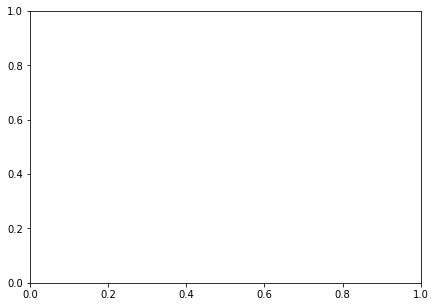

In [ ]:
import matplotlib.pyplot as plt
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
xc=range(150)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss, 'b', color='red')
plt.plot(xc,val_loss,'--', color = 'blue' )
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1.8)
plt.title('Training Loss vs Validation Loss')
plt.grid(True)
plt.legend(['Training Loss','Validation Loss'])
#print (plt.style.available) # use bmh, classic,ggplot for big pictures
plt.style.use(['seaborn'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc, 'b', color = 'red')
plt.plot(xc,val_acc, '--', color = 'blue')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylim(0, 1)

plt.grid(True)
plt.legend(['Training Accuracy','Validation Accuracy'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['seaborn'])